In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

import fannypack
from lib import dpf, panda_models, panda_datasets, panda_training, fusion_pf, fusion, omnipush_datasets

print(torch.__version__, np.__version__)

1.4.0 1.18.1


In [3]:
def eval_experiment(experiment_name):
    # Experiment configuration
    pf_image_model = panda_models.PandaParticleFilterNetwork(
        panda_models.PandaDynamicsModel(),
        panda_models.PandaMeasurementModel(units=64, missing_modalities=['gripper_force']),
    )

    pf_force_model = panda_models.PandaParticleFilterNetwork(
        panda_models.PandaDynamicsModel(),
        panda_models.PandaMeasurementModel(units=64, missing_modalities=['image']),
    )

    weight_model = fusion.CrossModalWeights(state_dim=1)

    pf_fusion_model = fusion_pf.ParticleFusionModel(
        pf_image_model,
        pf_force_model,
        weight_model
    )

    # Create buddy
    buddy = fannypack.utils.Buddy(
        experiment_name,
        pf_fusion_model,
        optimizer_names=[
            "e2e_fusion",
            "e2e_image",
            "e2e_force",
            "dynamics_image",
            "dynamics_force",
            "dynamics_recurrent_image",
            "dynamics_recurrent_force",
            "measurement_image",
            "measurement_force",
        ]
    )
    
    # Load eval data
    dataset_args = buddy.metadata
    eval_trajectories = panda_datasets.load_trajectories(
        "data/gentle_push_10.hdf5",
        **dataset_args
    )
    
    # Plotting, etc
    phases = [
        'phase_0_dynamics_pretrain',
        'phase_1_dynamics_pretrain_recurrent',
        'phase_2_measurement_pretrain',
        'phase_3_e2e_individual',
        'phase_4_e2e_joint',
        'phase_4_e2e_joint_unfrozen',
    ]
    for phase in phases:
        try:
            buddy.load_checkpoint(label=phase)
        except FileNotFoundError:
            print(f"Skipping {phase}")
            continue

        print(f"Evaluating {phase}")
        pf_fusion_model.image_model.dynamics_model.state_noise_stddev = (0.02, 0.02)
        pf_fusion_model.force_model.dynamics_model.state_noise_stddev = (0.02, 0.02)
        panda_training.rollout_and_eval(
            pf_fusion_model,
            eval_trajectories,
            start_time=0,
            max_timesteps=1000,
            particle_count=200,
            noisy_dynamics=True,
            true_initial=True)


In [5]:
eval_experiment("dpf_fusion_mujoco_blackout0")

[buddy-dpf_fusion_mujoco_blackout0] Using device: cuda
[buddy-dpf_fusion_mujoco_blackout0] Loaded metadata: {'image_blackout_ratio': 0.0, 'use_haptics': True, 'use_proprioception': True, 'use_vision': True, 'vision_interval': 2}
[buddy-dpf_fusion_mujoco_blackout0] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout0-0000000000209857.ckpt
[buddy-dpf_fusion_mujoco_blackout0] Loaded checkpoint at step: 209857
[buddy-dpf_fusion_mujoco_blackout0] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout0-phase_0_dynamics_pretrain.ckpt
[buddy-dpf_fusion_mujoco_blackout0] Loaded checkpoint at step: 37345
Evaluating phase_0_dynamics_pretrain


torch.Size([10, 32, 32])


IndexError: Dimension out of range (expected to be in range of [-3, 2], but got 3)

[buddy-dpf_fusion_mujoco_blackout4] Using device: cuda
[buddy-dpf_fusion_mujoco_blackout4] Loaded metadata: {'image_blackout_ratio': 0.4, 'use_haptics': True, 'use_proprioception': True, 'use_vision': True, 'vision_interval': 2}
[buddy-dpf_fusion_mujoco_blackout4] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout4-0000000000209857.ckpt
[buddy-dpf_fusion_mujoco_blackout4] Loaded checkpoint at step: 209857
[buddy-dpf_fusion_mujoco_blackout4] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout4-phase_0_dynamics_pretrain.ckpt
[buddy-dpf_fusion_mujoco_blackout4] Loaded checkpoint at step: 37345
Evaluating phase_0_dynamics_pretrain


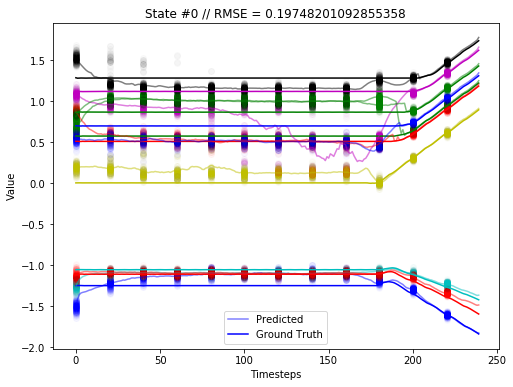

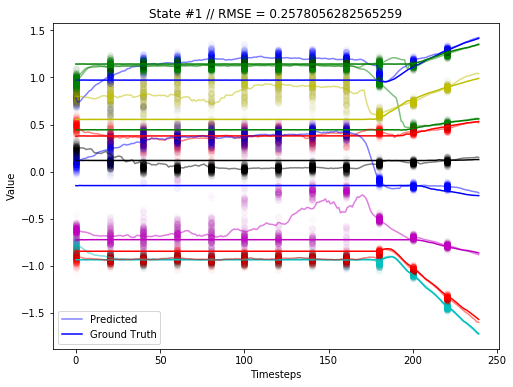

[buddy-dpf_fusion_mujoco_blackout4] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout4-phase_1_dynamics_pretrain_recurrent.ckpt
[buddy-dpf_fusion_mujoco_blackout4] Loaded checkpoint at step: 41097
Evaluating phase_1_dynamics_pretrain_recurrent


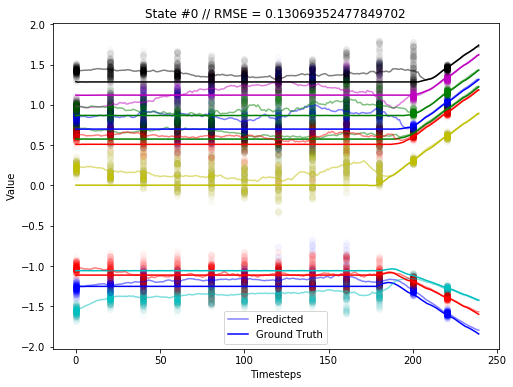

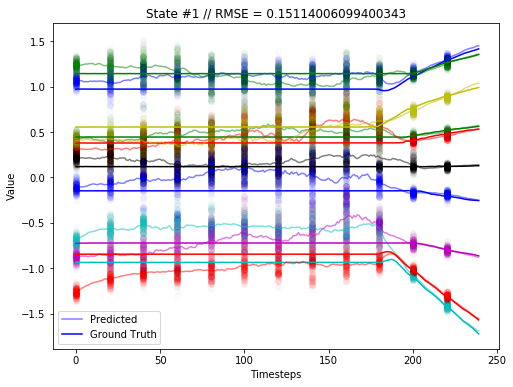

[buddy-dpf_fusion_mujoco_blackout4] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout4-phase_2_measurement_pretrain.ckpt
[buddy-dpf_fusion_mujoco_blackout4] Loaded checkpoint at step: 191097
Evaluating phase_2_measurement_pretrain


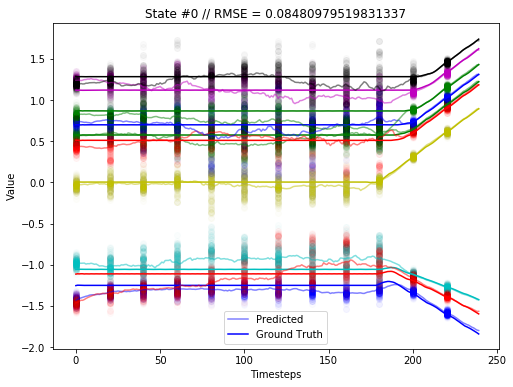

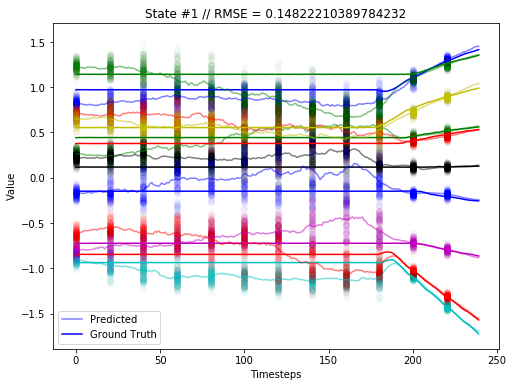

[buddy-dpf_fusion_mujoco_blackout4] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout4-phase_3_e2e_individual.ckpt
[buddy-dpf_fusion_mujoco_blackout4] Loaded checkpoint at step: 200477
Evaluating phase_3_e2e_individual


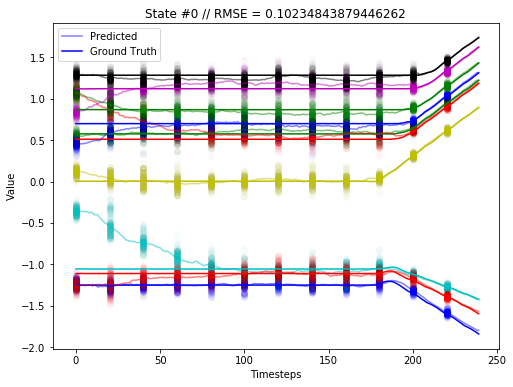

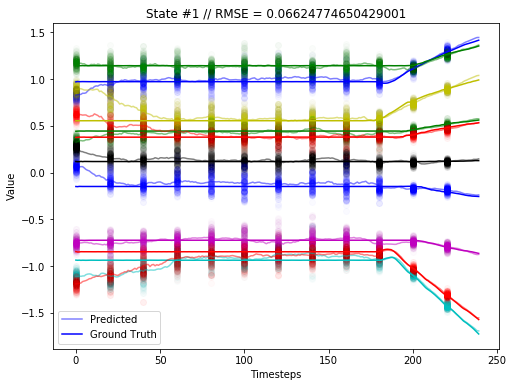

[buddy-dpf_fusion_mujoco_blackout4] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout4-phase_4_e2e_joint.ckpt
[buddy-dpf_fusion_mujoco_blackout4] Loaded checkpoint at step: 205167
Evaluating phase_4_e2e_joint


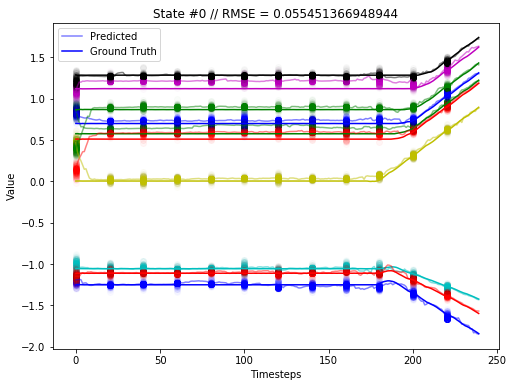

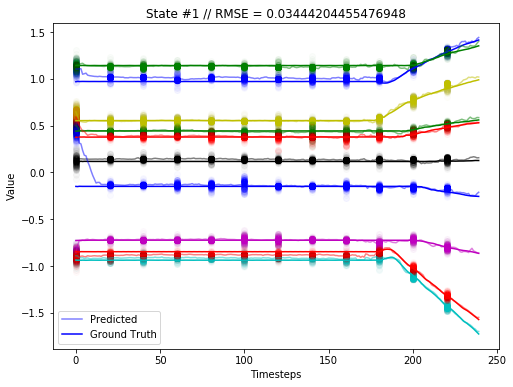

[buddy-dpf_fusion_mujoco_blackout4] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout4-phase_4_e2e_joint_unfrozen.ckpt
[buddy-dpf_fusion_mujoco_blackout4] Loaded checkpoint at step: 209857
Evaluating phase_4_e2e_joint_unfrozen


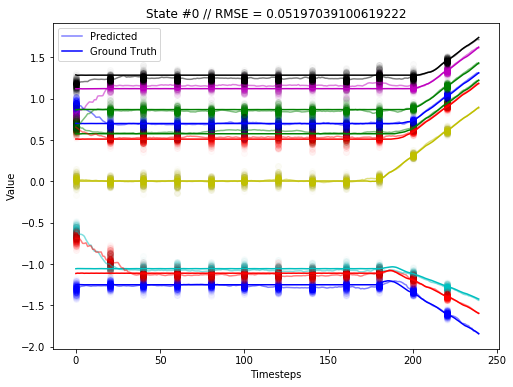

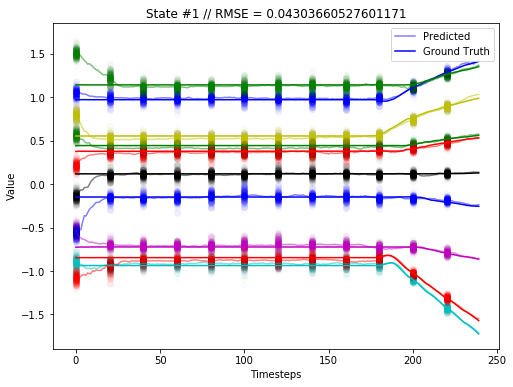

In [14]:
eval_experiment("dpf_fusion_mujoco_blackout4")

[buddy-dpf_fusion_mujoco_blackout8] Using device: cuda
[buddy-dpf_fusion_mujoco_blackout8] Loaded metadata: {'image_blackout_ratio': 0.8, 'use_haptics': True, 'use_proprioception': True, 'use_vision': True, 'vision_interval': 2}
[buddy-dpf_fusion_mujoco_blackout8] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout8-0000000000205167.ckpt
[buddy-dpf_fusion_mujoco_blackout8] Loaded checkpoint at step: 205167
[buddy-dpf_fusion_mujoco_blackout8] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout8-phase_0_dynamics_pretrain.ckpt
[buddy-dpf_fusion_mujoco_blackout8] Loaded checkpoint at step: 37345
Evaluating phase_0_dynamics_pretrain


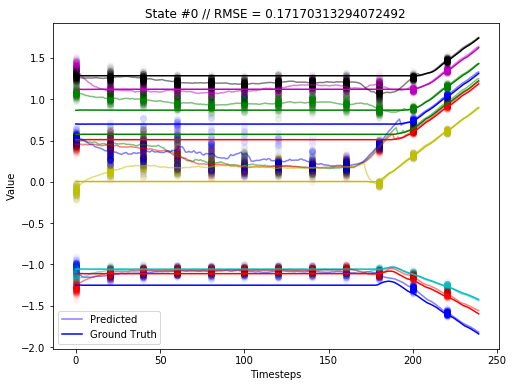

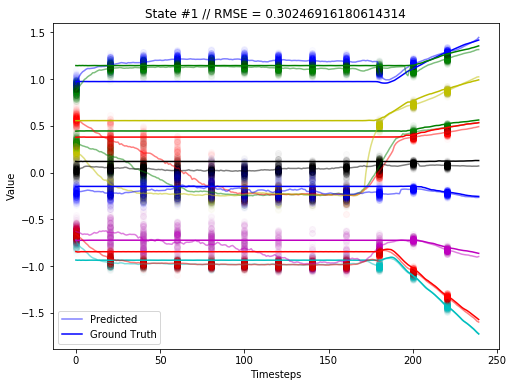

[buddy-dpf_fusion_mujoco_blackout8] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout8-phase_1_dynamics_pretrain_recurrent.ckpt
[buddy-dpf_fusion_mujoco_blackout8] Loaded checkpoint at step: 41097
Evaluating phase_1_dynamics_pretrain_recurrent


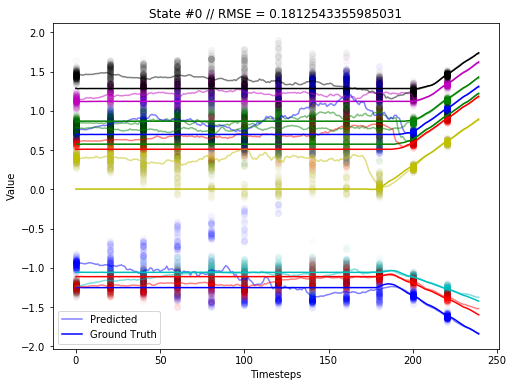

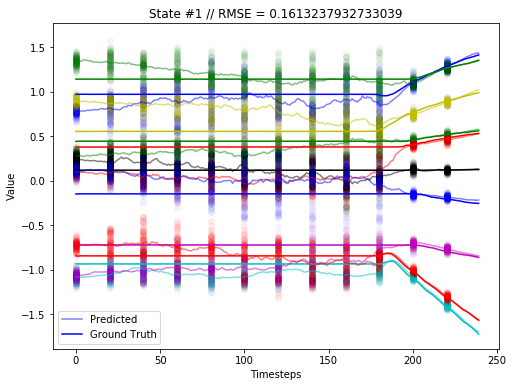

[buddy-dpf_fusion_mujoco_blackout8] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout8-phase_2_measurement_pretrain.ckpt
[buddy-dpf_fusion_mujoco_blackout8] Loaded checkpoint at step: 191097
Evaluating phase_2_measurement_pretrain


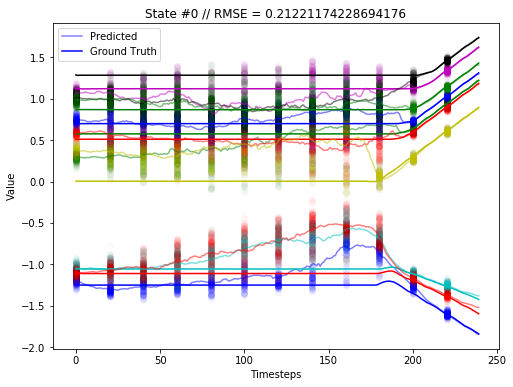

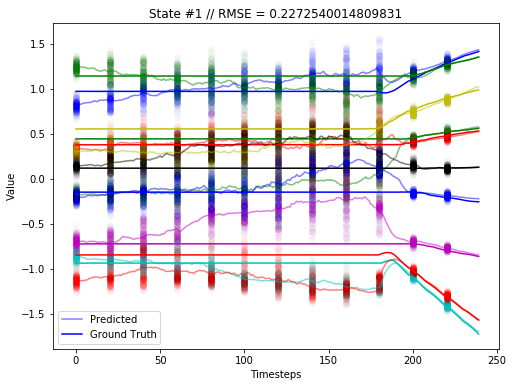

[buddy-dpf_fusion_mujoco_blackout8] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout8-phase_3_e2e_individual.ckpt
[buddy-dpf_fusion_mujoco_blackout8] Loaded checkpoint at step: 200477
Evaluating phase_3_e2e_individual


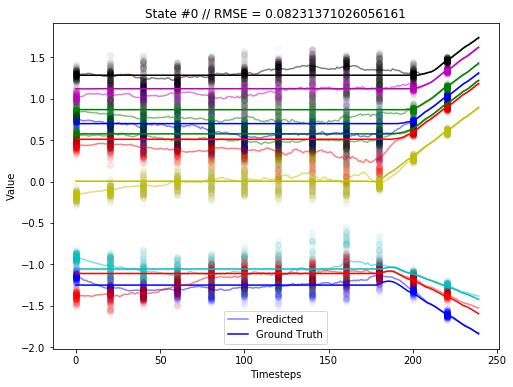

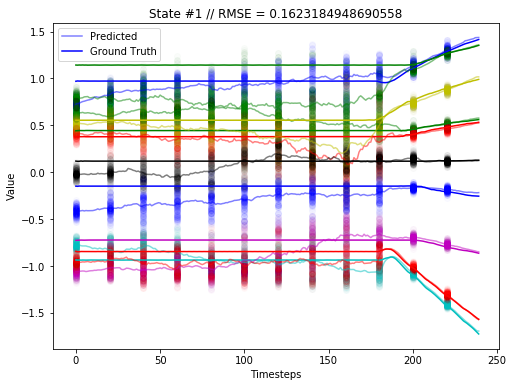

[buddy-dpf_fusion_mujoco_blackout8] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout8-phase_4_e2e_joint.ckpt
[buddy-dpf_fusion_mujoco_blackout8] Loaded checkpoint at step: 205167
Evaluating phase_4_e2e_joint


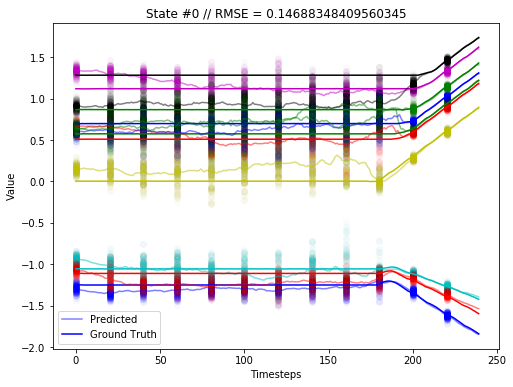

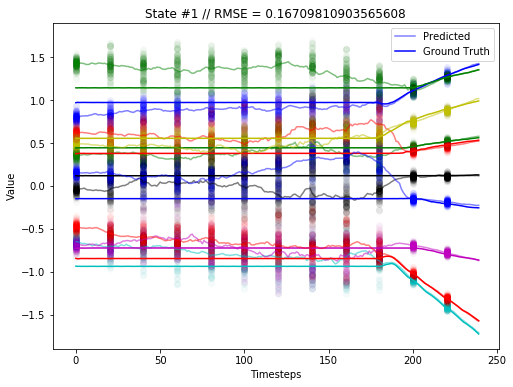

Skipping phase_4_e2e_joint_unfrozen


In [6]:
eval_experiment("dpf_fusion_mujoco_blackout8")